### Import libraries and data

In [1]:
import numpy as np
import sklearn.datasets, sklearn.decomposition
import matplotlib.pyplot as plt
from scipy.io import loadmat
file = loadmat('../data/static_FHA_FCs_5periods.mat')
FHA_FCs = file['sFC_5periods']
FHA_FCs.shape


(62, 286, 286, 5)

### Negative and positive family history of alcohol

In [45]:
alcohol_indices = loadmat('MATLAB/alcohol.mat')
neg_indices = alcohol_indices['neg_indices'][0]
pos_indices = alcohol_indices['pos_indices'][0]

Period 1: Pre-Task Rest\
Period 2: Pre-Task Rest 2\
Period 3: Task\
Period 4: Post-Task Rest\
Period 5: Post-Task Rest 2

### Split into rest and task

In [2]:
rest = FHA_FCs[:,:,:,0]
task = FHA_FCs[:,:,:,2]

nSubj = rest.shape[0]
nRegions = rest.shape[1]

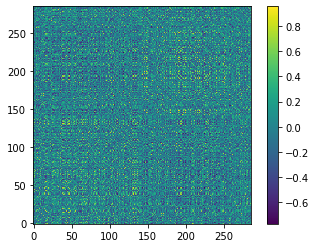

In [3]:
plt.imshow(rest[0],origin='lower')
plt.colorbar()
plt.show()

In [4]:
rest = rest.reshape(rest.shape[0],-1)
task = task.reshape(task.shape[0],-1)
nFCs = rest.shape[1]

**PCA and reconstruction**

In [5]:
mu_rest = np.mean(rest, axis=0)
mu_task = np.mean(task, axis=0)

nComp = int(0.5 * nSubj)
pca_rest = sklearn.decomposition.PCA()
pca_rest.fit(rest)

SCORES = pca_rest.transform(rest)[:,:nComp]
COEFFS = pca_rest.components_[:nComp,:]
pca_rest_recon = np.dot(SCORES, COEFFS)
pca_rest_recon += mu_rest

pca_rest_recon.shape

(62, 81796)

In [6]:
pca_task = sklearn.decomposition.PCA()
pca_task.fit(rest)

SCORES = pca_task.transform(task)[:,:nComp]
COEFFS = pca_task.components_[:nComp,:]
pca_task_recon = np.dot(SCORES, COEFFS)
pca_task_recon += mu_task

pca_task_recon.shape

(62, 81796)

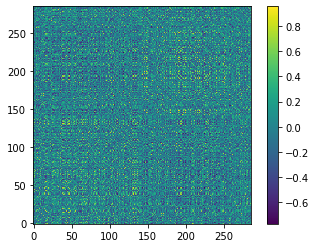

In [7]:
pca_rest_square = pca_rest_recon.reshape(nSubj, nRegions, nRegions)
plt.imshow(pca_rest_square[0],origin='lower')
plt.colorbar()
plt.show()

**Combine task and rest into dataset**

In [29]:
recon = np.vstack((pca_rest_recon, pca_task_recon))
recon.shape

(124, 81796)

## Identifiability Framework (for test-retest data)

In [9]:
# diag_mask = np.eye(rest.shape[0],dtype=bool)
# off_diag_mask = np.eye(rest.shape[0],dtype=bool)

# pca_task_square = pca_task_recon.reshape(nSubj, nRegions, nRegions)
# pca_rest_square = pca_rest_recon.reshape(nSubj, nRegions, nRegions)

# ident_task = np.mean(pca_task_square)

## Deep Learning

In [10]:
import torch
from torch import nn, optim
from torch.utils import data
from sklearn.preprocessing import StandardScaler

# GPU is available? If so, we use it.
use_cuda = torch.cuda.is_available() 
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    cudnn.benchmark = True

**Label data**

In [11]:
labels = torch.tensor(np.repeat(np.arange(0,2),nSubj))
indices = np.random.permutation(labels.shape[0])
train_idx = indices[:int(0.6*labels.shape[0])]
val_idx = indices[int(0.6*labels.shape[0]):int(0.8*labels.shape[0])]
test_idx = indices[int(0.8*labels.shape[0]):]

**Data normalization for training and validation**

In [12]:
std_scale = StandardScaler().fit(recon[train_idx,:])
recon[train_idx,:] = std_scale.transform(recon[train_idx,:])
recon[val_idx,:] = std_scale.transform(recon[val_idx,:])
recon[test_idx,:] = std_scale.transform(recon[test_idx,:])

In [13]:
recon = torch.Tensor(recon) 

In [14]:
train_data = []
for i in train_idx:
    train_data.append([recon[i], labels[i]])
    
val_data = []
for i in val_idx:
    val_data.append([recon[i], labels[i]])

test_data = []
for i in test_idx:
    test_data.append([recon[i], labels[i]])

In [15]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=100)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=100)

### Neural Network Architecture

In [16]:
input_size = recon.shape[1] # number of columns
hidden_sizes = [1024, 64]
output_size = 2
max_epochs = 10

In [17]:
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.BatchNorm1d(hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Dropout(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.BatchNorm1d(hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size))

In [18]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.05)
print(model)

Sequential(
  (0): Linear(in_features=81796, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=1024, out_features=64, bias=True)
  (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=2, bias=True)
)


### Training the Convolutional Neural Net

In [19]:

history = {}
history['loss'] = []
history['val_loss'] = []
history['acc'] = []
history['val_acc'] = []


# Loop over epochs


for epoch in range(max_epochs):
    # Training
    model.train()
    train_loss         = 0.0
    num_train_correct  = 0
    num_train_examples = 0
    for local_batch, local_labels in train_loader:
        # Transfer to GPU
        if use_cuda:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        
        

        opt.zero_grad()
        output = model(local_batch)
        loss = loss_fn(output, local_labels)
        loss.backward()
        opt.step()
        
        train_loss += loss.data.item() * local_batch.size(0)
        num_train_correct  += (torch.max(output, 1)[1] == local_labels).sum().item()
        num_train_examples += local_batch.shape[0]
        
        train_acc = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_loader.dataset)
        
    # Validation
    model.eval()
    val_loss       = 0.0
    num_val_correct  = 0
    num_val_examples = 0
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in val_loader:
            # Transfer to GPU
            if use_cuda:
                local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            output = model(local_batch)
            loss = loss_fn(output, local_labels)
            
            val_loss += loss.data.item() * local_batch.size(0)
            num_val_correct  += (torch.max(output, 1)[1] == local_labels).sum().item()
            num_val_examples += local_batch.shape[0]
            
        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_loader.dataset)
        
    print(f'Epoch {epoch+1}/{max_epochs}, train loss: {train_loss:5.4f}, train acc: {train_acc:5.3f}, val loss: {val_loss:5.3f}, val acc: {val_acc:5.3f}')
    
    
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['acc'].append(train_acc)
    history['val_acc'].append(val_acc)

Epoch 1/10, train loss: 0.9234, train acc: 0.446, val loss: 0.014, val acc: 1.000
Epoch 2/10, train loss: 0.2410, train acc: 0.986, val loss: 0.041, val acc: 1.000
Epoch 3/10, train loss: 0.1747, train acc: 1.000, val loss: 0.055, val acc: 1.000
Epoch 4/10, train loss: 0.1366, train acc: 0.986, val loss: 0.063, val acc: 1.000
Epoch 5/10, train loss: 0.1104, train acc: 1.000, val loss: 0.069, val acc: 1.000
Epoch 6/10, train loss: 0.0892, train acc: 1.000, val loss: 0.073, val acc: 1.000
Epoch 7/10, train loss: 0.0761, train acc: 1.000, val loss: 0.076, val acc: 1.000
Epoch 8/10, train loss: 0.0652, train acc: 1.000, val loss: 0.078, val acc: 1.000
Epoch 9/10, train loss: 0.0588, train acc: 1.000, val loss: 0.081, val acc: 1.000
Epoch 10/10, train loss: 0.0521, train acc: 1.000, val loss: 0.083, val acc: 1.000


In [20]:
model.eval()
num_correct  = 0
num_examples = 0
with torch.set_grad_enabled(False):
    for local_batch, local_labels in test_loader:
        # Transfer to GPU
        if use_cuda:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        output = model(local_batch)
        num_correct  += (torch.max(output, 1)[1] == local_labels).sum().item()
        num_examples += local_batch.shape[0]
            
    test_acc  = num_correct / num_examples

In [21]:
test_acc

0.96

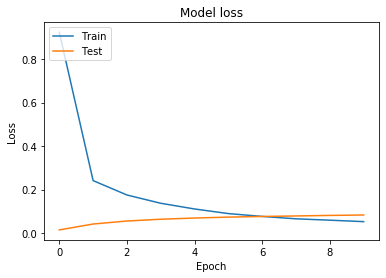

In [22]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

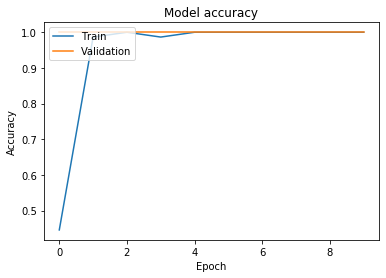

In [23]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Machine Learning Models

### SVM

In [24]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [25]:
clf = svm.SVC()
clf.fit(recon[train_idx,:], labels[train_idx])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [26]:
val_pred = clf.predict(recon[val_idx,:])
val_acc = accuracy_score(val_pred, labels[val_idx])

In [27]:
test_pred = clf.predict(recon[test_idx,:])
test_acc = accuracy_score(test_pred, labels[test_idx])

In [28]:
test_acc

1.0